In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# Read the CSV with proper delimiter and column names
prices_df_2024 = pd.read_csv('jeroen_punt_nl_dynamische_stroomprijzen_jaar_2024.csv',
                        sep=';',  # Set semicolon as delimiter
                        names=['datum_nl', 'datum_utc', 'prijs_excl_belastingen'],  # Define column names
                        skiprows=1)  # Skip the first row that contains headers
# read another CSV file, containing 2025 prices data
prices_df_2025 = pd.read_csv('jeroen_punt_nl_dynamische_stroomprijzen_jaar_2025.csv',
                              sep=';',  # Set semicolon as delimiter
                              names=['datum_nl', 'datum_utc', 'prijs_excl_belastingen'],  # Define column names
                              skiprows=1)  # Skip the first row that contains headers
# Convert the 'datum_utc' columns to datetime type
prices_df_2024['datum_utc'] = pd.to_datetime(prices_df_2024['datum_utc'],utc=True)
prices_df_2025['datum_utc'] = pd.to_datetime(prices_df_2025['datum_utc'], utc=True)

# Append the 2025 prices data to the 2024 prices data
prices_df = pd.concat([prices_df_2024, prices_df_2025], ignore_index=True)


# rename the 'prijs_excl_belastingen' column to 'price'
prices_df = prices_df.rename(columns={'prijs_excl_belastingen': 'price'})
# Convert price values decimal separator from comma to dot and convert to float
prices_df['price'] = prices_df['price'].str.replace(',', '.').astype(float) * 1
# drop 2025 values, as we only want 2024 data
prices_df = prices_df[prices_df['datum_utc'].dt.year == 2024]

# read another CSV file, containing 2024 CO2 emissions data, (not available for 2025)
co2_df = pd.read_csv("NED-2024.csv")
# Convert the 'datum_utc' columns (MM/DD/YY HH:MM)to datetime type
co2_df['validfrom (UTC)'] = pd.to_datetime(co2_df['validfrom (UTC)'], format='%m/%d/%y %H:%M', utc=True)
# Rename the 'validfrom (UTC)' column to 'datum_utc' and 'emission factor (gCO2eq/kWh)' to 'emission'
co2_df = co2_df.rename(columns={
    'validfrom (UTC)': 'datum_utc',
    'emission factor (gCO2eq/kWh)': 'CO2_emission_factor'
})
# Convert 'CO2_emission_factor' to numeric, handling any non-numeric values

'''print(co2_df.head())  # Display the first few rows to verify the conversion
print(prices_df.head())  # Display the first few rows to verify the conversion'''



# Rename the emission factor column in co2_df before merging
co2_df = co2_df.rename(columns={'emissionfactor (kg CO2/kWh)': 'CO2_emission_factor'})

# merge co2_df with prices_df on 'datum_utc'
df = prices_df.merge(co2_df[['datum_utc', 'CO2_emission_factor']], on='datum_utc', how='right')


# Convert 'CO2_emission_factor' to numeric, handling any non-numeric values
df['CO2_emission_factor'] = pd.to_numeric(df['CO2_emission_factor'], errors='coerce')

# drop validto (UTC), point, type, activity, timezone, granularity, percentage and  columns
df = df.drop(columns=['validto (UTC)', 'point', 'type', 'activity', 'timezone', 'granularity', 'percentage'], errors='ignore')

#drop any rows with co2_emission_factor or price values that are NaN
df = df.dropna(subset=['CO2_emission_factor', 'price'])
# print rows that were dropped due to NaN values
print("Rows dropped due to NaN values:")
print("")
# Display the first few rows to verify the structure
print(df.tail())

Rows dropped due to NaN values:

                 datum_nl                 datum_utc    price  \
8779  2024-12-31 19:00:00 2024-12-31 18:00:00+00:00  0.07056   
8780  2024-12-31 20:00:00 2024-12-31 19:00:00+00:00  0.05990   
8781  2024-12-31 21:00:00 2024-12-31 20:00:00+00:00  0.01820   
8782  2024-12-31 22:00:00 2024-12-31 21:00:00+00:00  0.00906   
8783  2024-12-31 23:00:00 2024-12-31 22:00:00+00:00  0.00052   

      CO2_emission_factor  
8779             0.094857  
8780             0.086264  
8781             0.083229  
8782             0.081749  
8783             0.077602  


Descriptive Statistics:
              price  CO2_emission_factor
count    8782.00000           8782.00000
mean        0.07716              0.20219
std         0.04962              0.10525
min        -0.20000              0.02248
25%         0.05649              0.10893
50%         0.08000              0.19851
75%         0.10059              0.29101
max         0.87296              0.43000
skewness    1.95808              0.15545
kurtosis   24.32465             -1.16231


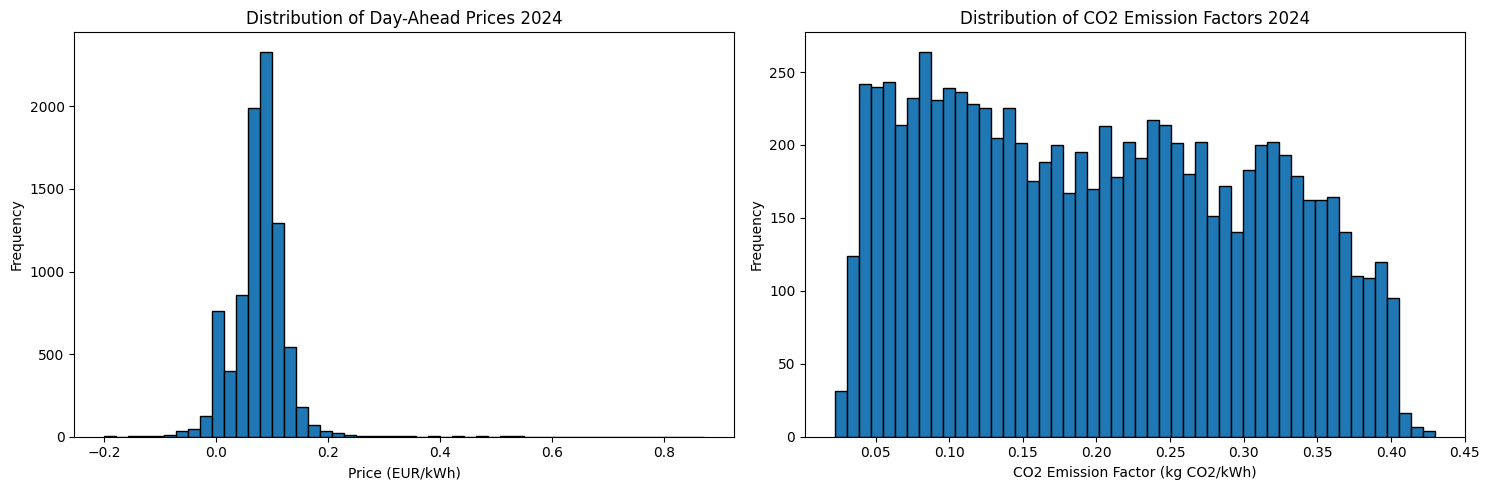

In [7]:
# Calculate descriptive statistics
stats = df[['price', 'CO2_emission_factor']].describe()

# Add additional metrics
stats.loc['skewness'] = df[['price', 'CO2_emission_factor']].skew()
stats.loc['kurtosis'] = df[['price', 'CO2_emission_factor']].kurtosis()

# Format the output
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x))
print("Descriptive Statistics:")
print(stats)

# Create histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Price histogram
ax1.hist(df['price'], bins=50, edgecolor='black')
ax1.set_title('Distribution of Day-Ahead Prices 2024')
ax1.set_xlabel('Price (EUR/kWh)')
ax1.set_ylabel('Frequency')

# CO2 emission factor histogram
ax2.hist(df['CO2_emission_factor'], bins=50, edgecolor='black')
ax2.set_title('Distribution of CO2 Emission Factors 2024')
ax2.set_xlabel('CO2 Emission Factor (kg CO2/kWh)')
ax2.set_ylabel('Frequency')

plt.tight_layout()

In [10]:
min_date = df['datum_utc'].min()
max_date = df['datum_utc'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")
# date types price and co2_emission_factor
print(f"Price type: {df['price'].dtype}")
print(f"CO2 Emission Factor type: {df['CO2_emission_factor'].dtype}")

Minimum date: 2024-01-01 00:00:00+00:00
Maximum date: 2024-12-31 22:00:00+00:00
Price type: float64
CO2 Emission Factor type: float64


In [14]:
def find_cheapest_block(df, start_date, horizon_days, block_size=4):
    # Define time window
    end_date = start_date + pd.Timedelta(days=horizon_days)
    mask = (df['datum_utc'] >= start_date) & (df['datum_utc'] < end_date)
    window_data = df[mask]

    # Compute rolling mean
    rolling_means = window_data['price'].rolling(window=block_size).mean()

    # Find minimum
    min_mean = rolling_means.min()
    min_idx = rolling_means.idxmin() # Get the index of the minimum mean

    if pd.notna(min_mean):
        return {
            'start_date': start_date,
            'horizon_days': horizon_days,
            'block_size': block_size,
            'avg_price': min_mean,
            'block_start_time': df.loc[min_idx, 'datum_utc']
        }
    else:
        return None

# Create analysis for all days and horizons
all_results = []
start_dates = prices_df['datum_utc'].dt.normalize().unique()
last_possible_date = prices_df['datum_utc'].max() - pd.Timedelta(days=1)

for start_date in start_dates:
    if start_date <= last_possible_date:
        for horizon in [1,4,7]:  # 1, 4 or 7 days
            result = find_cheapest_block(prices_df, start_date, horizon)
            if result:
                # Get the block start and end time
                block_start = result['block_start_time']
                block_end = block_start + pd.Timedelta(hours=4)
                # Calculate average CO2 emission for the block
                mask = (df['datum_utc'] >= block_start) & (df['datum_utc'] < block_end)
                avg_co2 = df.loc[mask, 'CO2_emission_factor'].mean()
                result['avg_co2'] = avg_co2
                all_results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# from 25 december missing values for avg_co2 start to occur, so drop any rows beyond that date
results_df = results_df[results_df['block_start_time'] < '2024-12-25']
print(results_df.tail())

                    start_date  horizon_days  block_size  avg_price  \
1071 2024-12-23 00:00:00+00:00             1           4    0.00789   
1072 2024-12-23 00:00:00+00:00             4           4    0.00789   
1073 2024-12-23 00:00:00+00:00             7           4    0.00789   
1074 2024-12-24 00:00:00+00:00             1           4    0.07982   
1075 2024-12-24 00:00:00+00:00             4           4    0.07982   

              block_start_time  avg_co2  
1071 2024-12-23 04:00:00+00:00  0.10048  
1072 2024-12-23 04:00:00+00:00  0.10048  
1073 2024-12-23 04:00:00+00:00  0.10048  
1074 2024-12-24 04:00:00+00:00  0.28534  
1075 2024-12-24 04:00:00+00:00  0.28534  


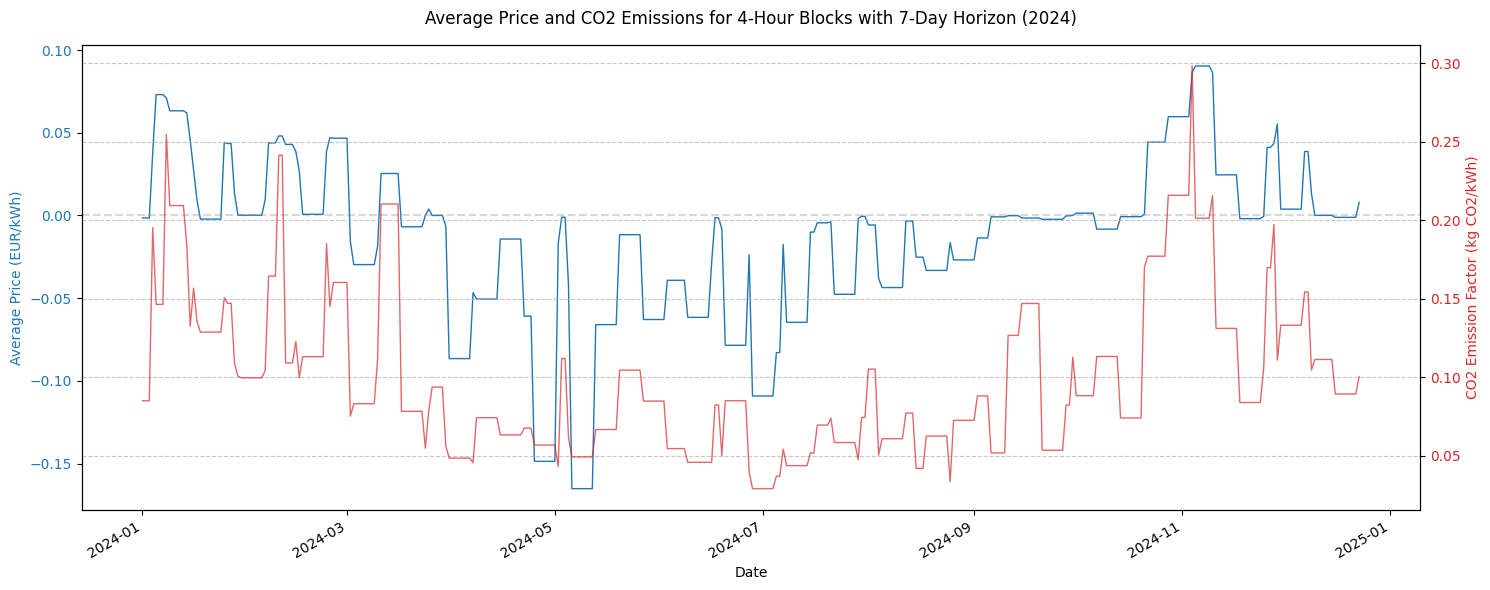

In [21]:
# Filter data for 7-day horizon and 4-hour blocks
horizon7_block4 = results_df[(results_df['horizon_days'] == 7) & (results_df['block_size'] == 4)]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot average price on primary axis
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon7_block4['start_date'], horizon7_block4['avg_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis for CO2 emissions
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('CO2 Emission Factor (kg CO2/kWh)', color=color2)
ax2.plot(horizon7_block4['start_date'], horizon7_block4['avg_co2'], color=color2, linewidth=1, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color2)

# Customize the plot
plt.title('Average Price and CO2 Emissions for 4-Hour Blocks with 7-Day Horizon (2024)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0 for price axis
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Calculate averages for 7-day horizon blocks
averages = horizon7_block4[['avg_price', 'avg_co2']].mean()
print("Averages for 7-day horizon, 4-hour blocks:")
print(f"Average price: {averages['avg_price']:.5f} EUR/kWh")
print(f"Average CO2 emission factor: {averages['avg_co2']:.5f} kg CO2/kWh")

# Also show standard deviations
std_devs = horizon7_block4[['avg_price', 'avg_co2']].std()
print("\nStandard deviations:")
print(f"Price std dev: {std_devs['avg_price']:.5f} EUR/kWh")
print(f"CO2 emission factor std dev: {std_devs['avg_co2']:.5f} kg CO2/kWh")

Averages for 7-day horizon, 4-hour blocks:
Average price: -0.01485 EUR/kWh
Average CO2 emission factor: 0.09870 kg CO2/kWh

Standard deviations:
Price std dev: 0.04951 EUR/kWh
CO2 emission factor std dev: 0.04986 kg CO2/kWh


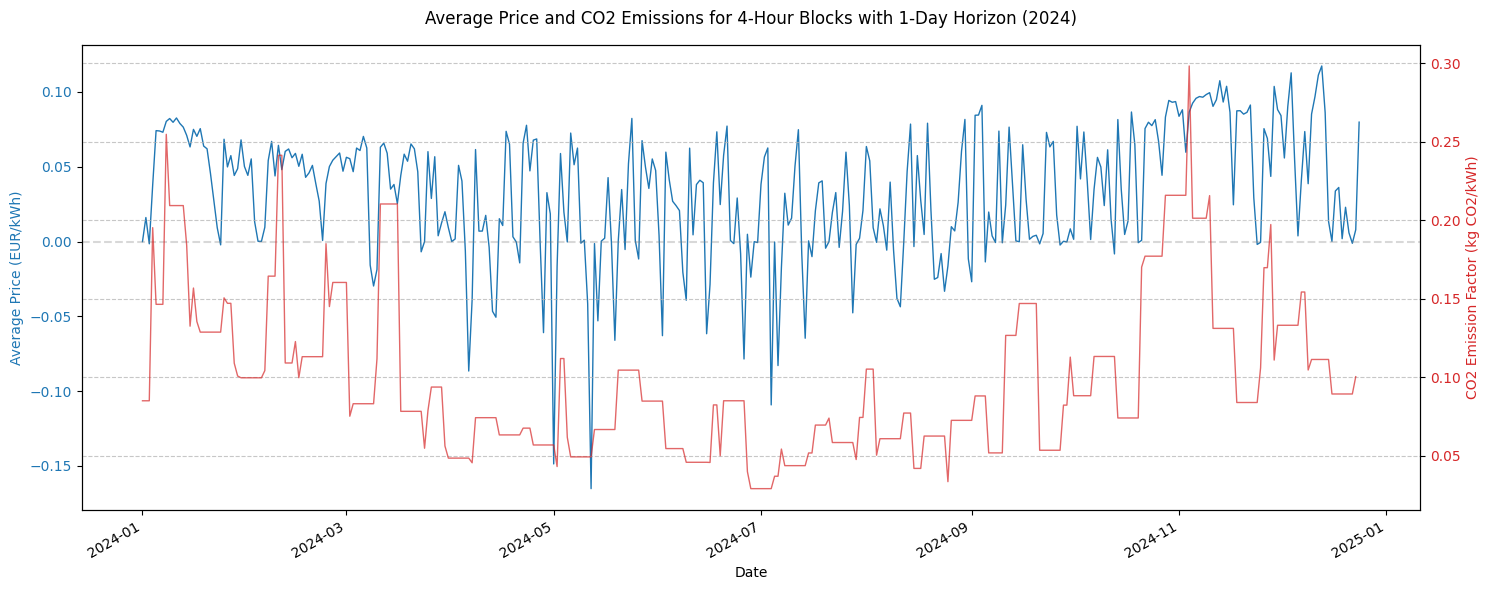

In [23]:
# Filter data for 1-day horizon and 4-hour blocks
horizon1_block4 = results_df[(results_df['horizon_days'] == 1) & (results_df['block_size'] == 4)]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot average price on primary axis
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon1_block4['start_date'], horizon1_block4['avg_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis for CO2 emissions
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('CO2 Emission Factor (kg CO2/kWh)', color=color2)
ax2.plot(horizon7_block4['start_date'], horizon7_block4['avg_co2'], color=color2, linewidth=1, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color2)

# Customize the plot
plt.title('Average Price and CO2 Emissions for 4-Hour Blocks with 1-Day Horizon (2024)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0 for price axis
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()

In [24]:
# Calculate averages for 1-day horizon blocks
averages = horizon1_block4[['avg_price', 'avg_co2']].mean()
print("Averages for 1-day horizon, 4-hour blocks:")
print(f"Average price: {averages['avg_price']:.5f} EUR/kWh")
print(f"Average CO2 emission factor: {averages['avg_co2']:.5f} kg CO2/kWh")

# Also show standard deviations
std_devs = horizon7_block4[['avg_price', 'avg_co2']].std()
print("\nStandard deviations:")
print(f"Price std dev: {std_devs['avg_price']:.5f} EUR/kWh")
print(f"CO2 emission factor std dev: {std_devs['avg_co2']:.5f} kg CO2/kWh")

Averages for 1-day horizon, 4-hour blocks:
Average price: 0.03283 EUR/kWh
Average CO2 emission factor: 0.15314 kg CO2/kWh

Standard deviations:
Price std dev: 0.04951 EUR/kWh
CO2 emission factor std dev: 0.04986 kg CO2/kWh


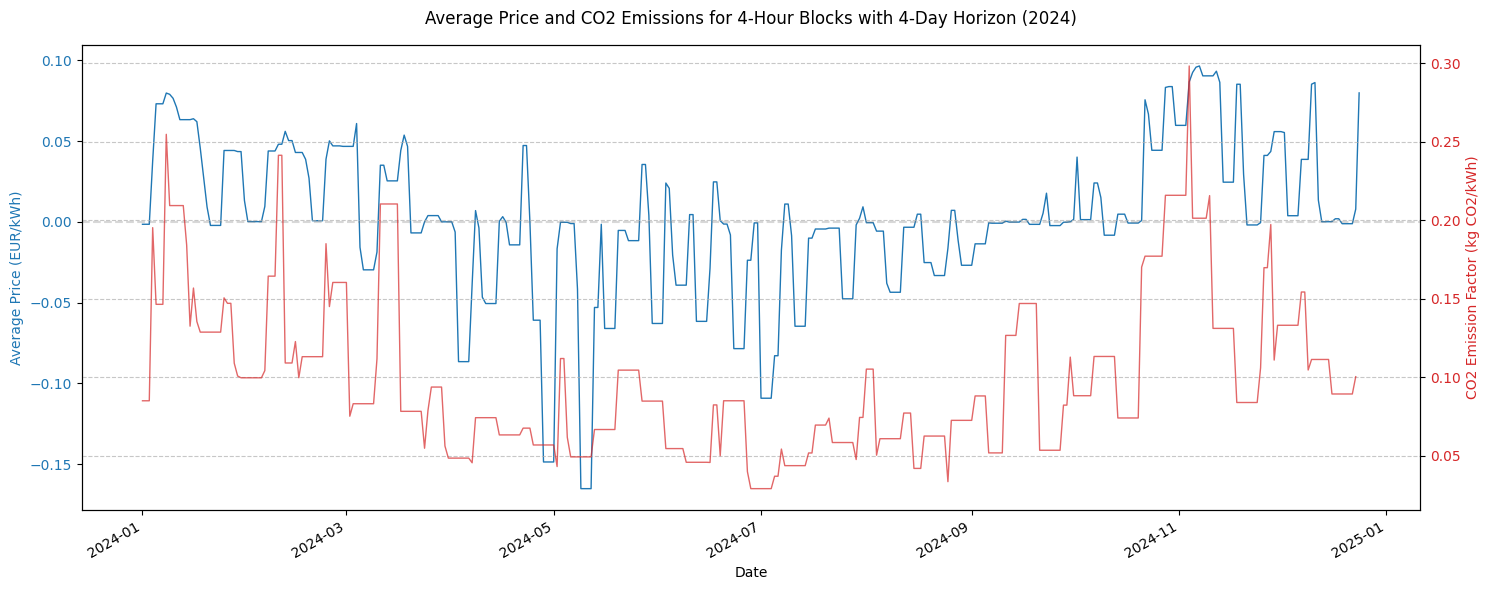

In [25]:
# Filter data for 4-day horizon and 4-hour blocks
horizon4_block4 = results_df[(results_df['horizon_days'] == 4) & (results_df['block_size'] == 4)]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot average price on primary axis
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon4_block4['start_date'], horizon4_block4['avg_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis for CO2 emissions
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('CO2 Emission Factor (kg CO2/kWh)', color=color2)
ax2.plot(horizon7_block4['start_date'], horizon7_block4['avg_co2'], color=color2, linewidth=1, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color2)

# Customize the plot
plt.title('Average Price and CO2 Emissions for 4-Hour Blocks with 4-Day Horizon (2024)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0 for price axis
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()

In [26]:
# Calculate averages for 4-day horizon blocks
averages = horizon4_block4[['avg_price', 'avg_co2']].mean()
print("Averages for 4-day horizon, 4-hour blocks:")
print(f"Average price: {averages['avg_price']:.5f} EUR/kWh")
print(f"Average CO2 emission factor: {averages['avg_co2']:.5f} kg CO2/kWh")

# Also show standard deviations
std_devs = horizon4_block4[['avg_price', 'avg_co2']].std()
print("\nStandard deviations:")
print(f"Price std dev: {std_devs['avg_price']:.5f} EUR/kWh")
print(f"CO2 emission factor std dev: {std_devs['avg_co2']:.5f} kg CO2/kWh")

Averages for 4-day horizon, 4-hour blocks:
Average price: 0.00061 EUR/kWh
Average CO2 emission factor: 0.11248 kg CO2/kWh

Standard deviations:
Price std dev: 0.04750 EUR/kWh
CO2 emission factor std dev: 0.06433 kg CO2/kWh


In [29]:
# Calculate baseline prices (1 day horizon) for each block size
baseline_prices = mean_prices[mean_prices['horizon_days'] == 1].set_index('block_size')['avg_price']

# Calculate savings relative to 1 day horizon
savings_df = mean_prices.copy()
for block in [4]:
    mask = savings_df['block_size'] == block
    savings_df.loc[mask, 'savings_per_kwh'] = baseline_prices[block] - savings_df.loc[mask, 'avg_price']
    
# Calculate annual savings based on 2500 kWh usage
savings_df['annual_savings'] = savings_df['savings_per_kwh'] * 2500

# Format and display results
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
print("\nSavings analysis (negative values indicate higher costs):")
print("=====================================================")
print(savings_df[['horizon_days', 'block_size', 'savings_per_kwh', 'annual_savings']])


Savings analysis (negative values indicate higher costs):
   horizon_days  block_size  savings_per_kwh  annual_savings
0             1           4           0.0000          0.0000
1             4           4           0.0322         80.5523
2             7           4           0.0477        119.2025


In [ ]:
# Get the baseline price for 1 day horizon and 4 hour blocks
baseline_price_4h = mean_prices[(mean_prices['horizon_days']==1) & (mean_prices['block_size']==4)]['avg_price'].values[0]

# Calculate annual cost
annual_cost_4h = baseline_price_4h * 2500


print(f"Average price per kWh (4h blocks): €{baseline_price_4h:.4f}")

print(f"Annual cost for 2500 kWh (4h blocks): €{annual_cost_4h:.2f}")

Average price per kWh (4h blocks): €0.0328
Annual cost for 2500 kWh (4h blocks): €82.07


In [32]:
# Base price per kWh (from baseline_price)
base_price = baseline_price_4h

# Additional costs (energy tax value 0.10154 EUR/kWh)
net_energy_tax = 0.10154

# Calculate subtotal
subtotal = base_price + net_energy_tax

# Add 21% VAT
total_with_vat = subtotal * 1.21

print(f"Base price per kWh: €{base_price:.4f}")
print(f"Additional costs per kWh: €{additional_costs:.4f}")
print(f"Subtotal per kWh: €{subtotal:.4f}")
print(f"Total price per kWh (incl. 21% VAT): €{total_with_vat:.4f}")

# Calculate annual cost for 2500 kWh
annual_cost_with_vat = total_with_vat * 2500
print(f"\nAnnual cost for 2500 kWh (incl. VAT): €{annual_cost_with_vat:.2f}")



Base price per kWh: €0.0328
Additional costs per kWh: €0.1015
Subtotal per kWh: €0.1344
Total price per kWh (incl. 21% VAT): €0.1626

Annual cost for 2500 kWh (incl. VAT): €406.46
